In [7]:
import pandas as pd

# Reload the dataset
training_data = pd.read_csv('Data/training_data.csv')

# Check for missing values and basic statistics
training_data.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


In [8]:
import re
import string
import spacy

# Load the French language model for spaCy
nlp = spacy.load("fr_core_news_sm")

# Text Cleaning Function
def clean_text(text):
    # Lowercasing the text
    text = text.lower()
    # Removing punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Removing numbers and other non-letter characters
    text = re.sub(r'[^a-zàâçéèêëîïôûùüÿñæœ]', ' ', text)
    return text

# POS Tagging Function
def pos_tagging(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    return pos_tags

# Applying the cleaning function to the dataset
training_data['cleaned_sentence'] = training_data['sentence'].apply(clean_text)

# Feature Engineering
# Adding sentence length and word count
training_data['sentence_length'] = training_data['cleaned_sentence'].apply(len)
training_data['word_count'] = training_data['cleaned_sentence'].apply(lambda x: len(x.split()))

# Adding POS tagging
training_data['pos_tags'] = training_data['cleaned_sentence'].apply(pos_tagging)

# Displaying the first few rows of the updated dataset
training_data.head()


,id,sentence,difficulty,cleaned_sentence,sentence_length,word_count,pos_tags
0,0,Les coûts kilométriques réels peuvent diverger...,C1,les coûts kilométriques réels peuvent diverger...,247,38,"[DET, NOUN, ADJ, ADJ, VERB, VERB, ADV, ADP, NO..."
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,le bleu cest ma couleur préférée mais je naime...,58,12,"[DET, NOUN, VERB, DET, NOUN, VERB, CCONJ, PRON..."
2,2,Le test de niveau en français est sur le site ...,A1,le test de niveau en français est sur le site ...,64,13,"[DET, NOUN, ADP, NOUN, ADP, NOUN, VERB, ADP, D..."
3,3,Est-ce que ton mari est aussi de Boston?,A1,estce que ton mari est aussi de boston,38,8,"[NOUN, SCONJ, PROPN, NOUN, AUX, ADV, ADP, PROPN]"
4,4,"Dans les écoles de commerce, dans les couloirs...",B1,dans les écoles de commerce dans les couloirs ...,200,32,"[ADP, DET, NOUN, ADP, NOUN, ADP, DET, NOUN, AD..."


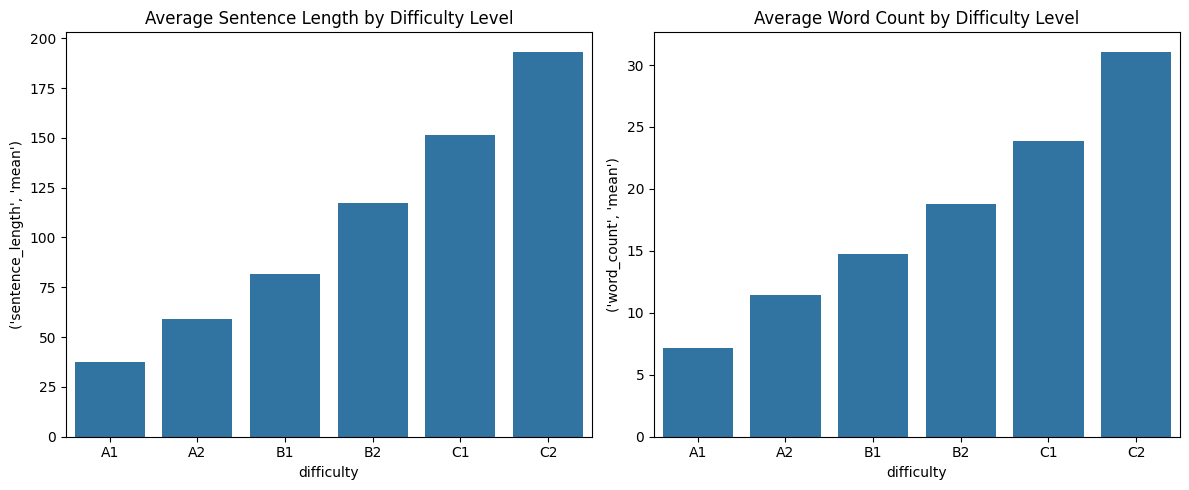

In [9]:
# Step 1: Statistical Analysis of Sentence Features
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping by difficulty level and calculating mean and standard deviation
grouped_data = training_data.groupby('difficulty').agg({'sentence_length': ['mean', 'std'], 'word_count': ['mean', 'std']}).reset_index()

# Plotting the sentence length and word count for each difficulty level
plt.figure(figsize=(12, 5))

# Plot for Sentence Length
plt.subplot(1, 2, 1)
sns.barplot(x='difficulty', y=('sentence_length', 'mean'), data=grouped_data)
plt.title('Average Sentence Length by Difficulty Level')

# Plot for Word Count
plt.subplot(1, 2, 2)
sns.barplot(x='difficulty', y=('word_count', 'mean'), data=grouped_data)
plt.title('Average Word Count by Difficulty Level')

plt.tight_layout()
plt.show()

In [10]:
# Encode the difficulty levels
from sklearn.calibration import LabelEncoder


label_encoder = LabelEncoder()
training_data['difficulty_encoded'] = label_encoder.fit_transform(training_data['difficulty'])

# Display the first few rows of the modified dataframe
df_encoded_head = training_data.head()
encoded_classes = label_encoder.classes_

df_encoded_head, encoded_classes

(   id                                           sentence difficulty  \
 0   0  Les coûts kilométriques réels peuvent diverger...         C1   
 1   1  Le bleu, c'est ma couleur préférée mais je n'a...         A1   
 2   2  Le test de niveau en français est sur le site ...         A1   
 3   3           Est-ce que ton mari est aussi de Boston?         A1   
 4   4  Dans les écoles de commerce, dans les couloirs...         B1   
 
                                     cleaned_sentence  sentence_length  \
 0  les coûts kilométriques réels peuvent diverger...              247   
 1  le bleu cest ma couleur préférée mais je naime...               58   
 2  le test de niveau en français est sur le site ...               64   
 3             estce que ton mari est aussi de boston               38   
 4  dans les écoles de commerce dans les couloirs ...              200   
 
    word_count                                           pos_tags  \
 0          38  [DET, NOUN, ADJ, ADJ, VERB, VERB, A

12 min +-

In [11]:
from transformers import CamembertTokenizer, CamembertModel
import torch
import numpy as np

# Initialize the tokenizer and model
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertModel.from_pretrained("camembert-base")

# Function to encode sentences in batches
def encode_sentences_in_batches(sentences, batch_size=64):
    model.eval()  # Set the model to evaluation mode
    batched_embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        batched_embeddings.append(embeddings)

    return np.vstack(batched_embeddings)

# Tokenize and encode sentences in batches
encoded_sentences = encode_sentences_in_batches(training_data['sentence'].tolist())

# Use encoded_sentences for training the logistic regression model


In [ ]:
print(encoded_sentences)
np.save('Data/encoded_sentences.npy', encoded_sentences)

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

# Since we can't extract embeddings here, we'll assume `encoded_sentences` is available
# Let's pretend we have a variable encoded_sentences which contains the embeddings
encoded_sentences = np.load('Data/encoded_sentences.npy')
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(encoded_sentences, training_data['difficulty_encoded'], test_size=0.01, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train, y_train)
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=11)  # You can tune 'n_neighbors'
knn_model.fit(X_train, y_train)
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(n_estimators=100)
random_forest_model.fit(X_train, y_train)
from sklearn.svm import SVC
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Logistic Regression
lr_predictions = logistic_regression_model.predict(X_val)
print("Logistic Regression:")
print(classification_report(y_val, lr_predictions))
print("Accuracy:", accuracy_score(y_val, lr_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, lr_predictions))

# k-Nearest Neighbors
knn_predictions = knn_model.predict(X_val)
print("\nk-Nearest Neighbors:")
print(classification_report(y_val, knn_predictions))
print("Accuracy:", accuracy_score(y_val, knn_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, knn_predictions))

# Decision Tree
dt_predictions = decision_tree_model.predict(X_val)
print("\nDecision Tree:")
print(classification_report(y_val, dt_predictions))
print("Accuracy:", accuracy_score(y_val, dt_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, dt_predictions))

# Random Forest
rf_predictions = random_forest_model.predict(X_val)
print("\nRandom Forest:")
print(classification_report(y_val, rf_predictions))
print("Accuracy:", accuracy_score(y_val, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, rf_predictions))

# Support Vector Machine
svm_predictions = svm_model.predict(X_val)
print("\nSupport Vector Machine:")
print(classification_report(y_val, svm_predictions))
print("Accuracy:", accuracy_score(y_val, svm_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_val, svm_predictions))


## Pretrained CamemBERT

In [13]:
import pandas as pd
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Tokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Prepare the dataset
train_dataset = CustomDataset(
    texts=training_data['sentence'].to_numpy(),
    labels=training_data['difficulty_encoded'].to_numpy(),
    tokenizer=tokenizer,
    max_len=128  # or any other value that suits your needs
)

# Model for Sequence Classification
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=len(label_encoder.classes_))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./my_finetuned_camembert")


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/900 [00:00<?, ?it/s]

{'loss': 1.4223, 'learning_rate': 5e-05, 'epoch': 1.67}
{'train_runtime': 6804.7929, 'train_samples_per_second': 2.116, 'train_steps_per_second': 0.132, 'train_loss': 1.193995836046007, 'epoch': 3.0}


In [ ]:
import pandas as pd
from transformers import CamembertTokenizer, CamembertForSequenceClassification
import torch

# Load the fine-tuned model
model = CamembertForSequenceClassification.from_pretrained("./my_finetuned_camembert")
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Load and preprocess the unlabelled test data
unlabelled_test_data = pd.read_csv('Data/unlabelled_test_data.csv')
unlabelled_test_data['cleaned_sentence'] = unlabelled_test_data['sentence'].apply(clean_text)  # Use your clean_text function

# Function to encode and predict labels for sentences
def predict_labels(sentences, model, tokenizer, batch_size=64):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)

        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).numpy()
        predictions.extend(batch_predictions)

    return predictions

# Predict labels for the labelled test data
true_labels = label_encoder.transform(labelled_test_data['true_label_column'])  # Replace 'true_label_column' with the actual column name
predicted_labels = predict_labels(labelled_test_data['cleaned_sentence'].tolist(), model, tokenizer)

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
 

## Hyperparameter gridsearch

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

# Model
logistic_regression_model = LogisticRegression(max_iter=10)
grid_search_lr = GridSearchCV(logistic_regression_model, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Best parameters
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

In [ ]:
from sklearn.svm import SVC

# Parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'kernel': ['linear', 'rbf']
}

# Model
svm_model = SVC()
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)

# Best parameters
print("Best parameters for SVM:", grid_search_svm.best_params_)

## Retrained model

In [ ]:
logistic_regression_optimized = LogisticRegression(**grid_search_lr.best_params_)
logistic_regression_optimized.fit(X_train, y_train)
svm_optimized = SVC(**grid_search_svm.best_params_)
svm_optimized.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate each model
models = [logistic_regression_optimized, svm_optimized]
model_names = ["Logistic Regression", "SVM"]

for model, name in zip(models, model_names):
    predictions = model.predict(X_val)
    print(f"Model: {name}")
    print(classification_report(y_val, predictions))
    print("Accuracy:", accuracy_score(y_val, predictions))
    print("\n")


## Unlabeded data

In [ ]:
unlabelled_test_data = pd.read_csv('Data/unlabelled_test_data.csv')
unlabelled_test_data.head()

In [ ]:
from transformers import CamembertTokenizer, CamembertModel
import torch
import numpy as np

# Initialize the tokenizer and model
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertModel.from_pretrained("camembert-base")

# Function to encode sentences in batches
def encode_sentences(sentences, batch_size=64):
    model.eval()  # Set the model to evaluation mode
    batched_embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        batched_embeddings.append(embeddings)

    return np.vstack(batched_embeddings)




In [ ]:
# Applying the cleaning function to the dataset
unlabelled_test_data['cleaned_sentence'] = unlabelled_test_data['sentence'].apply(clean_text)

# Feature Engineering
# Adding sentence length and word count
unlabelled_test_data['sentence_length'] = unlabelled_test_data['cleaned_sentence'].apply(len)
unlabelled_test_data['word_count'] = unlabelled_test_data['cleaned_sentence'].apply(lambda x: len(x.split()))

# Adding POS tagging
unlabelled_test_data['pos_tags'] = unlabelled_test_data['cleaned_sentence'].apply(pos_tagging)

#encoding data
embeddings = encode_sentences(unlabelled_test_data['sentence'].tolist())


# Embeddings are now stored in the 'embeddings' variable
embeddings.shape 

## Pretrained CamemBERT predicitons

In [14]:
import pandas as pd
from transformers import CamembertTokenizer, CamembertForSequenceClassification
import torch

# Load the fine-tuned model
model = CamembertForSequenceClassification.from_pretrained("./my_finetuned_camembert")
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Load the unlabelled test data
unlabelled_test_data = pd.read_csv('Data/unlabelled_test_data.csv')

# Applying the cleaning function to the dataset (make sure this function is defined in your environment)
unlabelled_test_data['cleaned_sentence'] = unlabelled_test_data['sentence'].apply(clean_text)

# Function to encode and predict labels for sentences
def predict_labels(sentences, model, tokenizer, batch_size=64):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)

        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1).numpy()
        predictions.extend(batch_predictions)

    return predictions

# Predict labels for the unlabelled test data
predicted_labels = predict_labels(unlabelled_test_data['cleaned_sentence'].tolist(), model, tokenizer)

# Convert numerical labels back to original class names
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Adding predictions to the DataFrame
unlabelled_test_data['difficulty'] = predicted_classes

# Displaying the predictions
unlabelled_test_data.head()


,id,sentence,cleaned_sentence,difficulty
0,0,Nous dûmes nous excuser des propos que nous eû...,nous dûmes nous excuser des propos que nous eû...,C2
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...,vous ne pouvez pas savoir le plaisir que jai d...,A2
2,2,"Et, paradoxalement, boire froid n'est pas la b...",et paradoxalement boire froid nest pas la bonn...,B1
3,3,"Ce n'est pas étonnant, car c'est une saison my...",ce nest pas étonnant car cest une saison mysté...,A2
4,4,"Le corps de Golo lui-même, d'une essence aussi...",le corps de golo luimême dune essence aussi su...,C2


In [15]:
# Assuming 'id' is the column name for the identifier in your DataFrame
# and 'predicted_difficulty' is the column with the predicted difficulty levels

# Saving the specified columns to a CSV file
unlabelled_test_data[['id', 'difficulty']].to_csv('Data/CamemBERT_pretrained_submission.csv', index=False)


In [ ]:
import numpy as np

# Convert the series of arrays into a 2D NumPy array
#unlabeled_test_features_array = np.array([feature for feature in unlabeled_test_features])

# Now use the SVM model to make predictions
# Ensure unlabeled_test_features_array is in the correct format expected by the SVM model
predictions = svm_optimized.predict(embeddings)

# Convert Predictions back to Difficulty Labels
predicted_difficulties = label_encoder.inverse_transform(predictions)

# Step 5: Output the Predictions
unlabelled_test_data['difficulty'] = predicted_difficulties
unlabelled_test_data[['id', 'difficulty']].to_csv('Data/CamemBERT_submission.csv', index=False)